In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
raw_loan_df = pd.read_csv('student_loan_data.csv')

In [3]:
# clean
raw_loan_df['Date'] = pd.to_datetime(raw_loan_df['Date'], dayfirst='True')
renamed_loan_df = raw_loan_df.rename(columns={'Transaction description' : 'Description', 'Debit (£)':'Debit', 'Credit (£)': 'Credit'})
renamed_loan_df.sort_values(by='Date', inplace=True)
renamed_loan_df.tail()

,Date,Description,Debit,Credit
75,2018-12-31,Interest 6.30%,316.14,0.0
76,2019-01-31,Interest 6.30%,317.78,0.0
77,2019-02-19,Repayment Received,0.00,84.0
78,2019-02-28,Interest 6.30%,288.38,0.0
79,2019-03-31,Interest 6.30%,320.49,0.0


In [4]:
# cumulative Debit
renamed_loan_df = renamed_loan_df.reset_index(drop=True)
for i in np.linspace(1, len(renamed_loan_df), len(renamed_loan_df)):
    renamed_loan_df.loc[i-1, 'Cumul_debit'] = renamed_loan_df.loc[:i-1, 'Debit'].sum()

In [5]:
# extract interest
renamed_loan_df['Interest'] = renamed_loan_df['Description'].apply(lambda x: x[-5:-2] if x.startswith('Interest') else 0)

In [6]:
renamed_loan_df.head(5)

,Date,Description,Debit,Credit,Cumul_debit,Interest
0,2014-04-06,Opening balance,0.00,0.0,0.00,0
1,2014-10-03,Maintenance Loan Payment,1719.63,0.0,1719.63,0
2,2014-10-15,Tuition Fee Loan Payment,2250.00,0.0,3969.63,0
3,2014-10-31,Interest 5.50%,12.37,0.0,3982.00,5.5
4,2014-11-30,Interest 5.50%,17.57,0.0,3999.57,5.5


In [7]:
tuition = 'Tuition Fee Loan Payment' 
maintenance = 'Maintenance Loan Payment'
print('Total Tuition Fee Loan Payment', renamed_loan_df.query('Description=="{}"'.format(tuition)).Debit.sum())
print('Maintenance Loan Payment', renamed_loan_df.query('Description=="{}"'.format(maintenance)).Debit.sum())
print('Paid Interest: ', renamed_loan_df.query('Description!="{}" and Description!="{}"'.format(tuition, maintenance)).Debit.sum())

Total Tuition Fee Loan Payment 36000.0
Maintenance Loan Payment 17728.0
Paid Interest:  8285.18


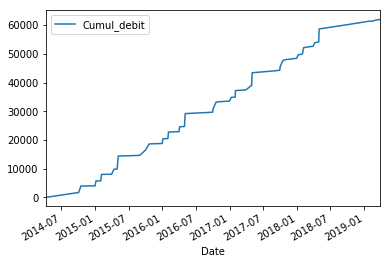

In [8]:
renamed_loan_df.plot(x='Date', y='Cumul_debit')

# Rules & payback model
1. Plan 2 loans are written off 30 years after the April you were first due to repay. In this case April 2049.
2. You repay 9% of the amount you earn over the monthly threshold of £2,143

Example: 
Your annual income is £28,800 and you are paid a regular monthly wage. This means that each month your income is £2,400 (£28,800 divided by 12). This is over the Plan 2 monthly threshold of £2,143.
Your income is £257 over the threshold (£2,400 minus £2,143). You will pay back £23 (9% of £257) each month.

In [9]:
def calc_monthly_payments(yearly_salary, one_shot):
        threshold = 2143
        monthly_payments = 0.09*((yearly_salary/12)-threshold)
        return monthly_payments+one_shot

In [10]:
def linear_yearly_salary_increase(current_yearly_salary, percent_increase):
    return current_yearly_salary+percent_increase*current_yearly_salary

In [11]:
def get_salaries(current_salary, percent_increase):    
    salaries = [current_salary]
    next_years_salary = current_salary
    number_of_years = 30
    years = [2019]
    for i in np.linspace(1, number_of_years, number_of_years):
        if next_years_salary < 300000:
            salaries.append(round(linear_yearly_salary_increase(next_years_salary, percent_increase), 2))
        else:
            salaries.append(300000)
        next_years_salary = linear_yearly_salary_increase(next_years_salary, percent_increase)
        years.append(years[0]+i)
    return salaries

In [12]:
def calculate_incremental_debt(output, starting_debt):
    debt = [starting_debt]
    for i, monthly_repayment in enumerate(output['Monthly Repayment'].values):
        debt[i] = debt[i]+debt[i]*output.loc[0, 'Interest']/12
        repayment = round(debt[i] - monthly_repayment, 2)
        if repayment > 0:
            debt.append(repayment)
        else:
            debt.append(0)
    return debt[:-1]

In [13]:
# desired output => dataframe with columns [Month, Year, Debt, Interest, Monthly Repayment, Predicted Salary]
def student_loan_model(current_debt, current_salary, salary_percent_increase, yearly_one_shot_percentage):
    salaries = get_salaries(current_salary, salary_percent_increase)
    yearly_df = pd.DataFrame({'Year': np.linspace(2019, 2019+30, 31)})
    yearly_df['Predicted Salary'] = salaries
    output = pd.DataFrame({'Date': pd.date_range(start='09/01/2019', end='09/01/2049', freq='M')})
    output['Year'] = output['Date'].apply(lambda x: x.year)
    output = output.merge(yearly_df)
    output['Interest'] = 0.063
    def h(x):
        return x['Predicted Salary']*yearly_one_shot_percentage if x['Date'].month==1 else 0
    output['Yearly One Shot Payback'] = output.apply(h, axis=1)
    def g(x):
        return calc_monthly_payments(x['Predicted Salary'], x['Yearly One Shot Payback'])
    output['Monthly Repayment'] = output.apply(g, axis=1)
    output['Total Repayment'] = output['Monthly Repayment'].cumsum()
    output['Debt'] = calculate_incremental_debt(output, current_debt)    
    def f(x):
        return x['Total Repayment'] if x['Debt']!=0 else 0
    output['Total Repayment'] = output.apply(f, axis=1)
    return output

In [14]:
# my params
with open('my_predicted_salary.json', 'r') as myfile:
    data=myfile.read()
# parse file
my_params = json.loads(data)

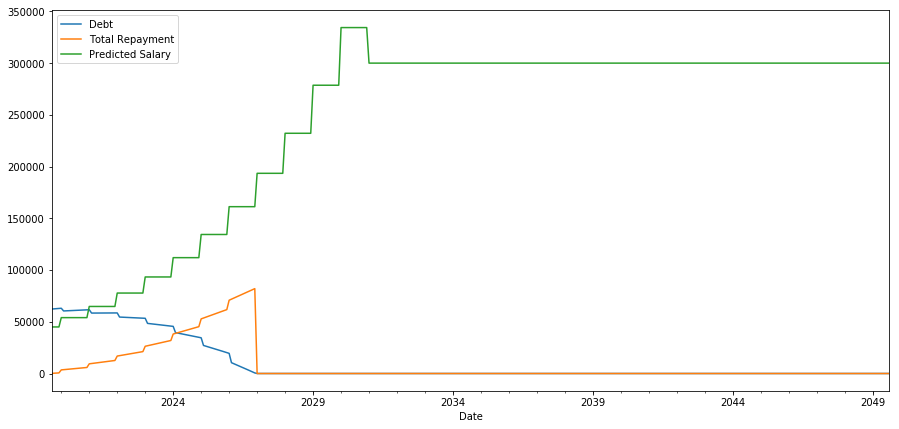

In [15]:
# Plot results
student_loan_model(my_params['current_debt'], my_params['current_salary'], my_params['salary_percent_increase'], my_params['yearly_one_shot_percentage']).plot(x='Date', y=['Debt', 'Total Repayment', 'Predicted Salary'], figsize=(15, 7))

In [16]:
final_df = student_loan_model(current_debt, current_salary, salary_percent_increase, yearly_one_shot_percentage)
max_payback = round(final_df['Total Repayment'].max(), 2)
date_payback = final_df.query('Debt==0')['Date'].min()
profit_off_my_ass = max_payback-53728
print(f'Total payment to those conts: {max_payback}')
print(f'Date of last payment: {str(date_payback)[:10]}')
print(f'Their total profit: {profit_off_my_ass}')

NameError: name 'current_debt' is not defined

In [ ]:
final_df.head(10)

In [ ]:
final_df['Yearly One Shot Payback'].sum()+final_df['Monthly Repayment'].sum()

In [ ]:
final_df[(final_df['Year']>=2029) & (final_df['Year']<=2031)]

In [ ]:
plt.figure(figsize=(17, 10))
for salary_percent_increase in np.linspace(0.01, 0.1, 20):
    res_df = student_loan_model(my_params['current_debt'], my_params['current_salary'], salary_percent_increase, my_params['yearly_one_shot_percentage'])
    plt.plot(res_df.Date.values, res_df['Total Repayment'].values, label='{}%'.format(round(100*salary_percent_increase, 2)))
plt.legend()
plt.show()